In [4]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [5]:
import pandas as pd
data = pd.read_csv('/content/gdrive/MyDrive/Train.csv')
data

,Image_ID,class,xmin,ymin,width,height
0,ID_007FAIEI,fruit_woodiness,87.0,87.5,228.0,311.0
1,ID_00G8K1V3,fruit_brownspot,97.5,17.5,245.0,354.5
2,ID_00WROUT9,fruit_brownspot,156.5,209.5,248.0,302.5
3,ID_00ZJEEK3,fruit_healthy,125.0,193.0,254.5,217.0
4,ID_018UIENR,fruit_brownspot,79.5,232.5,233.5,182.0
...,...,...,...,...,...,...
3901,ID_ZZAB1FH1,fruit_healthy,96.0,175.5,289.5,222.0
3902,ID_ZZAB1FH1,fruit_healthy,330.0,241.0,182.0,180.5
3903,ID_ZZJZ2CV6,fruit_healthy,358.0,234.0,134.5,107.0
3904,ID_ZZJZ2CV6,fruit_healthy,98.5,135.0,275.5,213.5


In [10]:
data['class'] = pd.Categorical(data['class'])
data['class_id'] = data['class'].cat.codes

In [11]:
data

,Image_ID,class,xmin,ymin,width,height,class_id
0,ID_007FAIEI,fruit_woodiness,87.0,87.5,228.0,311.0,2
1,ID_00G8K1V3,fruit_brownspot,97.5,17.5,245.0,354.5,0
2,ID_00WROUT9,fruit_brownspot,156.5,209.5,248.0,302.5,0
3,ID_00ZJEEK3,fruit_healthy,125.0,193.0,254.5,217.0,1
4,ID_018UIENR,fruit_brownspot,79.5,232.5,233.5,182.0,0
...,...,...,...,...,...,...,...
3901,ID_ZZAB1FH1,fruit_healthy,96.0,175.5,289.5,222.0,1
3902,ID_ZZAB1FH1,fruit_healthy,330.0,241.0,182.0,180.5,1
3903,ID_ZZJZ2CV6,fruit_healthy,358.0,234.0,134.5,107.0,1
3904,ID_ZZJZ2CV6,fruit_healthy,98.5,135.0,275.5,213.5,1


In [6]:
!unzip /content/gdrive/MyDrive/Train_Images.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: Train_Images/ID_8ORN0O9Z.jpg  
  inflating: __MACOSX/Train_Images/._ID_8ORN0O9Z.jpg  
  inflating: Train_Images/ID_PALLHD0G.jpg  
  inflating: __MACOSX/Train_Images/._ID_PALLHD0G.jpg  
  inflating: Train_Images/ID_R7GF24Z5.jpg  
  inflating: __MACOSX/Train_Images/._ID_R7GF24Z5.jpg  
  inflating: Train_Images/ID_9JNXXBZH.jpg  
  inflating: __MACOSX/Train_Images/._ID_9JNXXBZH.jpg  
  inflating: Train_Images/ID_LDN6A4IZ.jpg  
  inflating: __MACOSX/Train_Images/._ID_LDN6A4IZ.jpg  
  inflating: Train_Images/ID_MP5TK8IN.jpg  
  inflating: __MACOSX/Train_Images/._ID_MP5TK8IN.jpg  
  inflating: Train_Images/ID_A6BF0RI8.jpg  
  inflating: __MACOSX/Train_Images/._ID_A6BF0RI8.jpg  
  inflating: Train_Images/ID_7ZL4ON97.jpg  
  inflating: __MACOSX/Train_Images/._ID_7ZL4ON97.jpg  
  inflating: Train_Images/ID_AMQA4BYT.jpg  
  inflating: __MACOSX/Train_Images/._ID_AMQA4BYT.jpg  
  inflating: Train_Images/ID_DT

In [1]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-3sswl9zz
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-3sswl9zz
     |████████████████████████████████| 50 kB 2.8 MB/s 
     |████████████████████████████████| 74 kB 3.1 MB/s 
     |████████████████████████████████| 145 kB 42.1 MB/s 
     |████████████████████████████████| 130 kB 43.2 MB/s 
     |████████████████████████████████| 38.1 MB 1.4 MB/s 
     |████████████████████████████████| 843 kB 36.7 MB/s 
     |████████████████████████████████| 749 kB 42.6 MB/s 
     |████████████████████████████████| 596 kB 37.6 MB/s 
     |████████████████████████████████| 112 kB 43.1 MB/s 
  Created wheel for detectron2: filename=detectron2-0.6-cp37-cp37m-linux_x86_64.whl size=5689976 sha256=0377047e114231682352a4961cf2215f7a3c029999a2b4b1bbc826d92a9a66d9
  Stored in directory: /tmp/pip-ephem-wheel-cache-5xa96lku/wheels/07/dc/32/0322cb484dbefab8b9366bfedbaff5060ac7

In [3]:
import os
import copy
import pickle
import argparse
import json
import random
import sys
import time
import datetime
import logging


import pandas as pd
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold

import torch
from detectron2 import model_zoo
from detectron2.structures import BoxMode
import detectron2.data.transforms as T
from detectron2.data import detection_utils as utils
from detectron2.data import build_detection_test_loader, build_detection_train_loader
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch
from detectron2.evaluation import COCOEvaluator, PascalVOCDetectionEvaluator
from detectron2.config import CfgNode as CN
from detectron2.config import get_cfg
import detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.logger import setup_logger, log_every_n_seconds
from detectron2.utils.visualizer import Visualizer
from detectron2.engine.hooks import HookBase
import detectron2.utils.comm as comm

In [7]:
thingClasses = [
    "fruit_healthy",
    "fruit_woodiness",
    "fruit_brownspot"
]

cfgDict = {
    "dicomPath": "../input/vinbigdata-chest-xray-abnormalities-detection/train/",
    "orgDataPath": "../input/vinbigdata-chest-xray-abnormalities-detection/",
    "newDataPath": "/content/Train_Images",
    "cachePath": "./",
    "trainDataName": "vinbigdataTrain",
    "validDataName": "vinbigdataValid",
    "sampleSize": 1000,
    "imSize": 640,
    "modelName": "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml",
    "debug": False,
    "outdir": "./results/",
    "logFile": "log.txt",
    "splitMode": True,
    "seed": 111,
    "device": "cuda",
    "iter": 1000,
    "ims_per_batch": 16,
    "roi_batch_size_per_image": 512,
    "eval_period": 20,
    "lr_scheduler_name": "WarmupCosineLR",
    "base_lr": 0.001,
    "checkpoint_period":500,
    "num_workers": 4,
    "score_thresh_test": 0.05,
    "augKwargs": {
        "RandomFlip": {"prob": 0.5},
        "RandomRotation": {"angle": [0,360]}
    }
}

setup_logger(os.path.join(cfgDict["outdir"],cfgDict["logFile"]))

<Logger detectron2 (DEBUG)>

In [ ]:
data.Image_ID

In [30]:
def getDatasetDicts(cfg,dfTrain,dataType="train",imSize=600,cache=False):
    """Function to create dataset dicts"""
    
    
    datasetDicts = []
    for index,row in dfTrain.iterrows():
            datasetDict = {}
            annotations = []

            imageId = row['Image_ID']
            filename = os.path.join('/content/Train_Images',row['Image_ID']+".jpg")
            datasetDict["file_name"] = filename
            datasetDict["image_id"] = imageId
            datasetDict["height"] = imSize
            datasetDict["width"] = imSize
            
            # Add annotations for training/validation data
            classId = row["class_id"]
            bboxResized = [ float(row["xmin"]),
                                        float(row["ymin"]),
                                        float(row["xmin"] + row["width"]),
                                        float(row["ymin"] + row["height"])]     
            annotation = { "bbox": bboxResized,
                                    "bbox_mode": BoxMode.XYXY_ABS,
                                    "category_id": classId }
            annotations.append(annotation)
            datasetDict["annotations"] = annotations
            
            datasetDicts.append(datasetDict)

     
    return datasetDicts

In [32]:
class AugMapper:
    """Custom mapper class for augmentations"""

    def __init__(self, cfg, isTrain=True):
        augKwargs = cfg["augKwargs"]
        augList = []
        # Define a sequence of augmentations
        if isTrain:
            augList.extend([getattr(T, name)(**kwargs) for name, kwargs in augKwargs.items()])
        self.augmentations = T.AugmentationList(augList)
        self.isTrain = isTrain

    def __call__(self, datasetDict):
        datasetDict = copy.deepcopy(datasetDict)  # it will be modified by code below
        image = utils.read_image(datasetDict["file_name"], format="BGR")
        augInput = T.AugInput(image) # the augmentation input
        transforms = self.augmentations(augInput) # apply the augmentation
        image = augInput.image # new image
        imShape = image.shape[:2]  # h, w
        datasetDict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32")) # HWC to CHW
        annos = [ utils.transform_instance_annotations(annotation, transforms, imShape) 
                    for annotation in datasetDict.pop("annotations") 
                    if annotation.get("iscrowd", 0) == 0 ] # apply the augmentation to annotation
        instances = utils.annotations_to_instances(annos, imShape)
        datasetDict["instances"] = utils.filter_empty_instances(instances)
        
        return datasetDict

In [33]:
class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        comm.synchronize()

        return mean_loss
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
        
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            mean_loss = self._do_loss_eval()
            self.trainer.storage.put_scalars(validation_loss=mean_loss)
            print("validation do loss eval", mean_loss)

In [34]:
class MyTrainer(DefaultTrainer):
    """Overwrite DefaultTrainer methods"""
    
    @classmethod
    def build_train_loader(cls, cfg, sampler=None):
        return build_detection_train_loader(
            cfg, mapper=AugMapper(cfg, True), sampler=sampler
        )

    @classmethod
    def build_test_loader(cls, cfg, datasetName):
        return build_detection_test_loader(
            cfg, datasetName, mapper=AugMapper(cfg, False)
        )

    @classmethod
    def build_evaluator(cls, cfg, datasetName, outputFolder=None):
        if outputFolder is None:
            outputFolder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(datasetName, ("bbox",), False, output_dir=outputFolder)
    
    def build_hooks(self):
        hooks = super(MyTrainer, self).build_hooks()
        cfg = self.cfg
        if len(cfg.DATASETS.TEST) > 0:
            loss_eval_hook = LossEvalHook(
                cfg.TEST.EVAL_PERIOD,
                self.model,
                MyTrainer.build_test_loader(cfg, cfg.DATASETS.TEST[0]),
            )
            hooks.insert(-1, loss_eval_hook)

        return hooks

In [35]:
datasetDicts = getDatasetDicts(cfgDict,data,dataType="train",imSize=600,cache=False)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=cfgDict["seed"])
y = np.array([int(len(d["annotations"]) > 0) for d in datasetDicts])
splitIdx = list(skf.split(datasetDicts, y))
trainIdx, validIdx = splitIdx[0]

In [36]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2)

In [38]:
DatasetCatalog.clear()
DatasetCatalog.register(
        cfgDict["trainDataName"],
        lambda: getDatasetDicts(cfgDict,dfTrain=train,dataType="train",cache=True)
    )
MetadataCatalog.get(cfgDict["trainDataName"]).set(thing_classes=thingClasses)

Metadata(name='vinbigdataTrain', thing_classes=['fruit_healthy', 'fruit_woodiness', 'fruit_brownspot'])

In [39]:
DatasetCatalog.register(
        cfgDict["validDataName"],
        lambda: getDatasetDicts(cfgDict,dfTrain=test,dataType="valid",cache=True)
    )
MetadataCatalog.get(cfgDict["validDataName"]).set(thing_classes=thingClasses)

Metadata(name='vinbigdataValid', thing_classes=['fruit_healthy', 'fruit_woodiness', 'fruit_brownspot'])

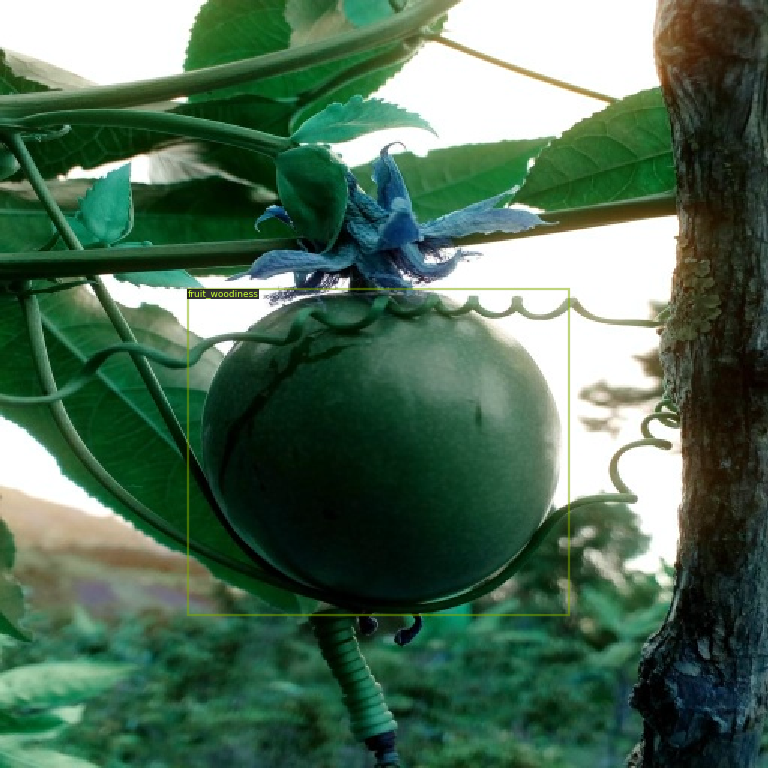

In [40]:
vinbigdataMetadata = MetadataCatalog.get(cfgDict["validDataName"])
d = datasetDicts[3]
img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=vinbigdataMetadata, scale=1.5)
out = visualizer.draw_dataset_dict(d)
Image.fromarray(out.get_image()[:, :, ::-1])

In [41]:
cfg = get_cfg()

cfg.augKwargs = CN(cfgDict["augKwargs"])  # pass augKwargs to cfg as a CN
cfg.merge_from_file(model_zoo.get_config_file(cfgDict["modelName"]))
cfg.MODEL.DEVICE = cfgDict["device"]
cfg.OUTPUT_DIR = cfgDict["outdir"]
cfg.DATASETS.TRAIN = (cfgDict["trainDataName"],)
if cfgDict["splitMode"] is None:
    cfg.DATASETS.TEST = ()
else:
    cfg.DATASETS.TEST = (cfgDict["validDataName"],)
    cfg.TEST.EVAL_PERIOD = cfgDict["eval_period"]
cfg.DATALOADER.NUM_WORKERS = cfgDict["num_workers"]
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(cfgDict["modelName"])
cfg.SOLVER.IMS_PER_BATCH = cfgDict["ims_per_batch"]
cfg.SOLVER.LR_SCHEDULER_NAME = cfgDict["lr_scheduler_name"]
cfg.SOLVER.BASE_LR = cfgDict["base_lr"]
cfg.SOLVER.MAX_ITER = cfgDict["iter"]
cfg.SOLVER.CHECKPOINT_PERIOD = cfgDict["checkpoint_period"]
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = cfgDict["roi_batch_size_per_image"]
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(thingClasses)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[03/29 20:16:17 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[03/29 20:16:20 d2.data.build]: Distribution of instances among all 3 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
| fruit_healthy | 207          | fruit_woodi.. | 325          | fruit_brown.. | 250          |
|               |              |               |              |               |              |
|     total     | 782          |               |              |               |              |
[03/29 20:16:20 d2.data.common]: Serializing 782 elements to byte tensors and concatenating them all ...
[03/29 20:16:20 d2.data.common]: Serialized dataset takes 0.19 MiB


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
model_final_280758.pkl: 167MB [00:02, 56.5MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.b

[03/29 20:16:23 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[03/29 20:18:42 d2.data.common]: Serializing 782 elements to byte tensors and concatenating them all ...
[03/29 20:18:43 d2.data.common]: Serialized dataset takes 0.19 MiB
[03/29 20:18:43 d2.evaluation.coco_evaluation]: Trying to convert 'vinbigdataValid' to COCO format ...
[03/29 20:18:43 d2.data.datasets.coco]: Converting annotations of dataset 'vinbigdataValid' to COCO format ...)
[03/29 20:18:43 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[03/29 20:18:43 d2.data.datasets.coco]: Conversion finished, #images: 782, #annotations: 782
[03/29 20:18:43 d2.data.datasets.coco]: Caching COCO format annotations at './results/inference/vinbigdataValid_coco_format.json' ...
[03/29 20:18:43 d2.evaluation.evaluator]: Start inference on 782 batches
[03/29 20:18:45 d2.evaluation.evaluator]: Inference done 11/782. Dataloading: 0.0026 s/iter. Inference: 0.1601 s/iter. Eval: 0.0004 s/iter. Total: 0.1632 s/iter. ETA=0:02:05
[03/29 20:18:50 d2.evaluation.evaluator]: Inference done 